<font color='blue' size=5><b>Комментарий ревьювера</b></font>

<font color='blue'>Привет, Павел! Меня зовут Григорий Звездин, и я буду проверять этот проект. Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>

<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>зеленый текст - все отлично</font>

<font color='orange'>оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>красный текст - есть недочеты</font>


---

<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='blue'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

## Построение модели прогноза количества заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков в данных и аномальных значений не выявлено. Преобразуем столбец datetime к соответствующему формату.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Отлично! Данные на месте и первый осмотр выполнен :)

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Убедимся что данные расположены в хронологическом порядке.

In [6]:
df['datetime'].is_monotonic

True

Установим столбец datetime в качестве индекса и передискретезируем данные с временным интервалом в 1 час.

In [7]:
df = df.set_index('datetime').resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Молодец!

# 2. Анализ

Для начала посмотрим на график предоставленного временного ряда.

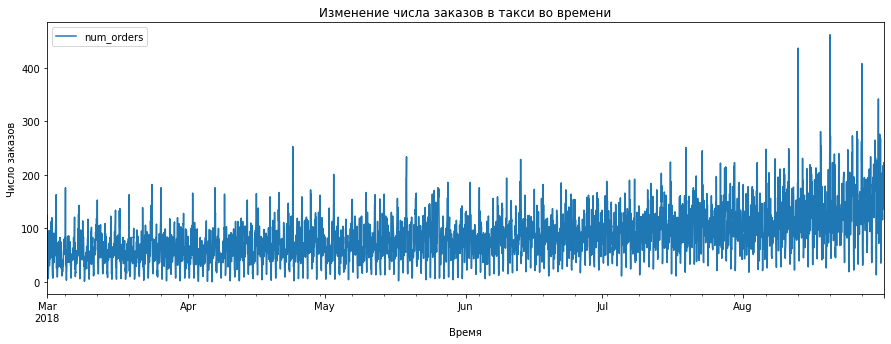

In [8]:
(df.plot(y='num_orders', figsize=(15,5))
.set(xlabel='Время',
     ylabel='Число заказов',
     title='Изменение числа заказов в такси во времени'));

По графику видно что в данных присутствует некоторый повышательный тренд. Попробуем разложить временной ряд на тренд и сезонность.

In [9]:
decomposed = seasonal_decompose(df)

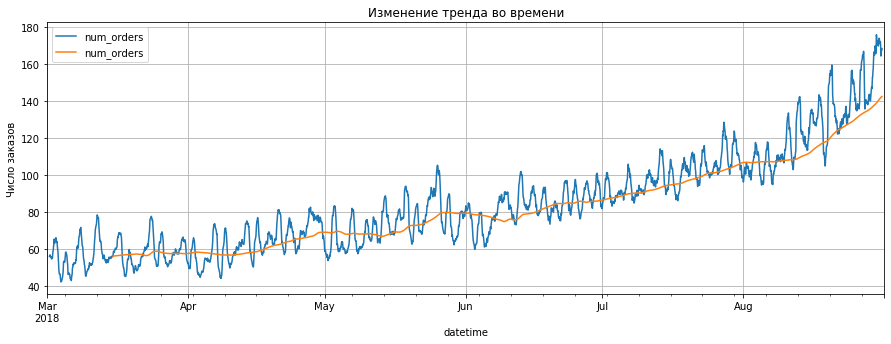

In [10]:
(decomposed.trend.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Изменение тренда во времени'));
decomposed.trend.rolling(24*7*2).mean().plot(ax=plt.gca(), grid=True);

На графике выше приведено изменение тренда во времени, а так же среднее значение тренда за 2 недели. По графику видно, что тренд со временем увеличивается, причем увеличение нелинейное. Рассмотрим сезонную составляющую.

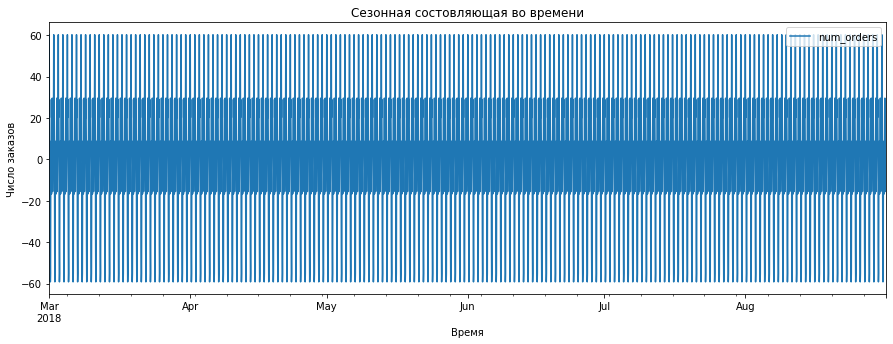

In [11]:
(decomposed.seasonal.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Сезонная состовляющая во времени'));

Поближе посмотрим как меняется сезонная составляющая в течении недели.

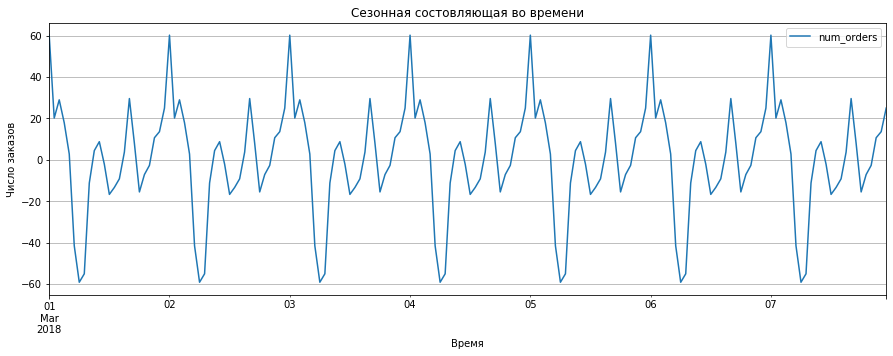

In [12]:
(decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(15,5), grid=True)
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Сезонная состовляющая во времени'));

Внути одного дня виден повторяющийся паттерн увеличения числа заказов в течении дня достигающий своего пика к полуночи и после этого резко спадающий. Для полноты картины так же выведем остатки (заказы не попавшие в тренд и сезонность).

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Правильное замечание, наблюдается сезонность в течение дня

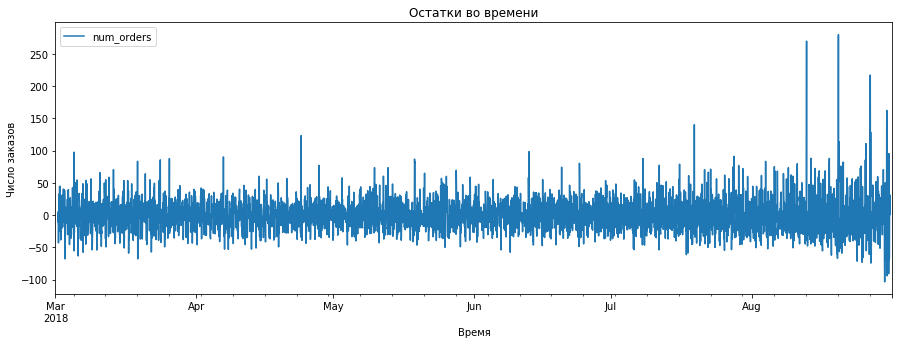

In [13]:
(decomposed.resid.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Остатки во времени'));

Создадим функцию которая будет генерировать признаки для обучения моделей. Помимо задержанных отсчетов самого временного ряда включим в состав признаков день недели и текущий час (из-за сезонности), а так же некоторые элементы ряда Тейлора от скользящего среднего (из-за нелинейного тренда).

In [14]:
def features_generation(df, max_lag=1, rolling_mean_size=24):
    try:
        df['dayofweek'] = df.index.dayofweek
        df['hour'] = df.index.hour
        df['rolling_mean_2'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 2
        df['rolling_mean_3'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 3
        df['rolling_mean_4'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 4
        for lag in range(1, max_lag+1):
            col_name = 'lag_' + str(lag)
            df[col_name] = df['num_orders'].shift(lag)

    except:
        print('Ошибка в функции features_generation')

In [15]:
features_generation(df, 24*7, 24*7)
df.head(5)

,num_orders,dayofweek,hour,rolling_mean_2,rolling_mean_3,rolling_mean_4,lag_1,lag_2,lag_3,lag_4,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,NaN,NaN,NaN,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,NaN,NaN,NaN,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,NaN,NaN,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,NaN,NaN,NaN,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Молодец, что объяснил выбор признаков!

Удалим начало временного ряда в котором оказались незаполненые признаки

In [16]:
df = df.dropna()

# 3. Обучение

Разделим выборку на обучающую и тестовую, причем в качестве тестовой выборки будем использовать последний доступный отрезок временного ряда

In [17]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Верно\
Но оставлю заметку: если будет подбор гиперпараметров, то нужно либо делить выборку на три части, либо делать кросс-валидацию

<b>Про кросс-валидацию временных рядов:</b>(дополнительные материалы)\
В случае с временным рядом нам нужно задать кросс-валидацию TimeSeriesSplit\
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html \
Если мы исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.\
Иллюстрация работы:\
</font>
![image.png](https://scikit-learn.org/dev/_images/sphx_glr_plot_cv_indices_010.png)

Код реализации:
<code>
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X, y)</code></font>

In [18]:
len(train)

3823

In [19]:
len(test)

425

In [20]:
len(train) + len(test) == len(df)

True

Создадим списки с целевым признаком и фичами.

In [21]:
y_col = ['num_orders']
x_col = df.columns.drop(y_col)
x_col

Index(['dayofweek', 'hour', 'rolling_mean_2', 'rolling_mean_3',
       'rolling_mean_4', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       ...
       'lag_159', 'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164',
       'lag_165', 'lag_166', 'lag_167', 'lag_168'],
      dtype='object', length=173)

### Линейная регрессия

In [22]:
lr_model = LinearRegression()
lr_model.fit(train[x_col], train[y_col])
train_lr_RMSE = np.sqrt(mean_squared_error(train[y_col], lr_model.predict(train[x_col])))
test_lr_RMSE = np.sqrt(mean_squared_error(test[y_col], lr_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_lr_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_lr_RMSE))

RMSE на обучающей выборке: 20.4785
RMSE на тестовой выборке: 33.9419


### CatBoost

In [23]:
train_res, val = train_test_split(train, test_size=0.1, shuffle=False)

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Хорошо!

In [24]:
len(train_res) + len(val) == len(train)

True

In [25]:
train_pool = Pool(train_res[x_col], train_res[y_col])
val_pool = Pool(val[x_col], val[y_col])

In [26]:
cb_model = CatBoostRegressor(random_state=42, verbose=50, iterations=100, learning_rate=0.2)
cb_model.fit(train_pool, eval_set=[val_pool]);

0:	learn: 32.6446841	test: 53.7707786	best: 53.7707786 (0)	total: 80.6ms	remaining: 7.98s
50:	learn: 17.0618016	test: 30.0225959	best: 30.0225959 (50)	total: 4.15s	remaining: 3.99s
99:	learn: 14.1552613	test: 30.0714548	best: 29.7522535 (85)	total: 8.33s	remaining: 0us

bestTest = 29.75225347
bestIteration = 85

Shrink model to first 86 iterations.


In [27]:
train_cb_RMSE = np.sqrt(mean_squared_error(train[y_col], cb_model.predict(train[x_col])))
test_cb_RMSE = np.sqrt(mean_squared_error(test[y_col], cb_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_cb_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_cb_RMSE))

RMSE на обучающей выборке: 17.0027
RMSE на тестовой выборке: 43.3720


# 4. Тестирование

Сравним точность полученных моделей с константной моделью.

In [28]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(train[x_col], train[y_col])
train_dummy_RMSE = np.sqrt(mean_squared_error(train[y_col], dummy_model.predict(train[x_col])))
test_dummy_RMSE = np.sqrt(mean_squared_error(test[y_col], dummy_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_dummy_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_dummy_RMSE))

RMSE на обучающей выборке: 38.8461
RMSE на тестовой выборке: 84.4511


И модель CatBoost, и модель линейной регрессии дают RMSE на тестовой выборке лучше константной модели, что говорит о возможности их использования.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Супер :) проверка на адекватность важна всегда, чтобы определить целесообразность проектирования моделей

# Выводы

В процессе исследования были выполнены следующие работы:
1. Проведена подготовка и анализ данных.
2. Обучено несколько моделей прогнозирования количества заказов. Рассмотренные модели:
    * CatBoost;
    * Линейная регрессия.
3. Проведено тестирование моделей и сравнение с константным предсказанием.

Константная модель дает СКО на тестовой выборке (последние 10% заданного временного ряда): 84.4511. Обе рассмотренные модели дают точность лучше чем константная и лучше чем требуемая точность по заданию (не более 48). СКО предсказаний CatBoost на тестовой выборке 43.3720, линейной регрессии - 33.9419. 

Разработанная модель линейной регрессии рекомендуется для дальнейшего использования.

<font color='blue'><b>Итоговый комментарий ревьювера</b></font>\
<font color='green'>Павел, добротный проект! Надеюсь, что тебе понравилась тема временных рядов, ниже я оставлю несколько ссылок. Кроме использованных в проекте способов предсказать временной ряд, существует еще модель ARIMA и Facebook Prophet</font>

<font color='blue'><b>Проект принят! Успехов :)</b></font>

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Дополнительные материалы:\
Базовое применение ARIMA - https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing \
Канторович - Анализ временных рядов https://yadi.sk/i/IOkUOS3hTXf3gg \
https://facebook.github.io/prophet/ \
https://facebook.github.io/prophet/docs/quick_start.html#python-api \
https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb 
    

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48